In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train = pd.read_csv('~/Downloads/training.csv')
test = pd.read_csv('~/Downloads/test.csv')
lookup = pd.read_csv('~/Downloads/IdLookupTable.csv')

na_cols = train.columns[train.isna().any()].tolist()
train = train.fillna(train[na_cols].mean())
X_train = train['Image'].apply(lambda img: np.fromstring(img, sep=' '))
X_train = np.vstack(X_train.values).reshape(-1, 96, 96).astype(np.uint8)

Y_train = train.drop(['Image'], axis=1)
Y_train = Y_train.values.astype(np.float32)

X_test = test['Image'].apply(lambda img: np.fromstring(img, sep=' '))
X_test = np.vstack(X_test.values).reshape(-1, 96, 96).astype(np.uint8)

In [2]:
X_train = X_train / 255
X_test = X_test / 255

In [7]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D


model = Sequential()
# input layer
model.add(BatchNormalization(input_shape=(96, 96, 1)))
model.add(Conv2D(24, (5, 5), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(36, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(48, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 5
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
# layer 6
model.add(Dense(500, activation="relu"))
# layer 7
model.add(Dense(90, activation="relu"))
# layer 8
model.add(Dense(30))

In [4]:
from keras import optimizers
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y_train = output_pipe.fit_transform(Y_train)

sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 50

X_train = X_train.reshape(-1, 96, 96, 1)
history = model.fit(X_train, y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

Instructions for updating:
Use tf.cast instead.
Train on 5639 samples, validate on 1410 samples
Epoch 1/50
5639/5639 [==============================] - 143s 25ms/step - loss: 0.0115 - acc: 0.4962 - val_loss: 0.0032 - val_acc: 0.5518
Epoch 2/50
5639/5639 [==============================] - 94s 17ms/step - loss: 0.0094 - acc: 0.4981 - val_loss: 0.0033 - val_acc: 0.5418
Epoch 3/50
5639/5639 [==============================] - 88s 16ms/step - loss: 0.0094 - acc: 0.5185 - val_loss: 0.0031 - val_acc: 0.5418
Epoch 4/50
5639/5639 [==============================] - 88s 16ms/step - loss: 0.0093 - acc: 0.5473 - val_loss: 0.0032 - val_acc: 0.5723
Epoch 5/50
5639/5639 [==============================] - 88s 16ms/step - loss: 0.0091 - acc: 0.5735 - val_loss: 0.0033 - val_acc: 0.5574
Epoch 6/50
5639/5639 [==============================] - 86s 15ms/step - loss: 0.0086 - acc: 0.6067 - val_loss: 0.0033 - val_acc: 0.6553
Epoch 7/50
5639/5639 [==============================] - 90s 16ms/step - loss: 0.0080 - 

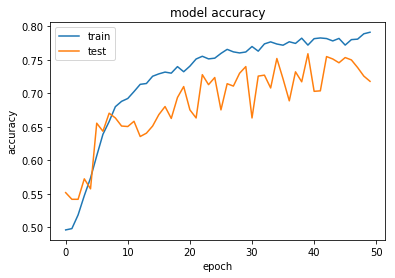

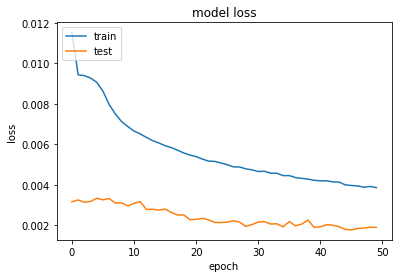

In [5]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
X_test = X_test.reshape(-1, 96, 96, 1)
pred = model.predict(X_test)

lookid_list = list(lookup['FeatureName'])
imageID = list(lookup['ImageId']-1)
pre_list = list(pred)
rowid=list(lookup['RowId'])

feature = []
for f in list(lookup['FeatureName']):
    feature.append(lookid_list.index(f))
    
preded = []
for x,y in zip(imageID, feature):
    preded.append(pre_list[x][y])
    
    
rowid = pd.Series(rowid, name='RowId')
loc = pd.Series(preded, name='Location')
submission = pd.concat([rowid, loc], axis=1)
submission.to_csv('facial_submission4.csv',index = False)